<a href="https://colab.research.google.com/github/hyposse/L42Project_Tutoriels/blob/master/Copie_de_VAE_with_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [VAE2] - VAE, using a custom model class  (MNIST dataset)
<!-- DESC --> Construction and training of a VAE, using model subclass, with a latent space of small dimension.

<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Understanding and implementing a **variational autoencoder** neurals network (VAE)
 - Understanding a still more **advanced programming model**, using a **custom model**

The calculation needs being important, it is preferable to use a very simple dataset such as MNIST to start with.  
...MNIST with a small scale if you haven't a GPU ;-)

## What we're going to do :

 - Defining a VAE model
 - Build the model
 - Train it
 - Have a look on the train process

## Acknowledgements :
Thanks to **François Chollet** who is at the base of this example (and the creator of Keras !!).  
See : https://keras.io/examples/generative/vae


In [ ]:
#!mkdir data_faces && wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
!ls



celeba.zip  data_faces	drive  sample_data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive/test/VAE/modules

import sys
sys.path.append('/content/drive/MyDrive/test/VAE/')
%pip install fidle
run_dir='/content/drive/MyDrive/test/VAE/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
callbacks  datagen  layers  models
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.3 MB/s eta 0:00:00


## Step 1 - Init python stuff

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import sys

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import TensorBoard

from modules.models    import VAE
from modules.layers    import SamplingLayer
from modules.callbacks import ImagesCallback, BestModelCallback
from modules.datagen   import MNIST

import fidle

# Init Fidle environment
#run_id, run_dir, datasets_dir = fidle.init('VAE2')

VAE.about()

<br>**FIDLE 2021 - VAE**

Version              : 1.4
TensorFlow version   : 2.12.0
Keras version        : 2.12.0


## Step 2 - Parameters
`scale` : with scale=1, we need 1'30s on a GPU V100 ...and >20' on a CPU !  
`latent_dim` : 2 dimensions is small, but usefull to draw !  
`fit_verbosity`: Verbosity of training progress bar: 0=silent, 1=progress bar, 2=One line  

`loss_weights` : Our **loss function** is the weighted sum of two loss:
 - `r_loss` which measures the loss during reconstruction.  
 - `kl_loss` which measures the dispersion.  

The weights are defined by: `loss_weights=[k1,k2]` where : `total_loss = k1*r_loss + k2*kl_loss`  
In practice, a value of \[1,.01\] gives good results here.


In [94]:
latent_dim    = 200
loss_weights  = [100,0.7]       # [1, .001] give good results

scale         = .3
#seed          = 135

batch_size    = 128
epochs        = 5
fit_verbosity = 1

Override parameters (batch mode) - Just forget this cell

In [95]:
fidle.override('latent_dim', 'loss_weights', 'scale',  'batch_size', 'epochs', 'fit_verbosity')

In [ ]:
fidle.override('latent_dim', 'loss_weights', 'scale', 'seed', 'batch_size', 'epochs', 'fit_verbosity')

## Step 3 - Prepare data
`MNIST.get_data()` return : `x_train,y_train, x_test,y_test`,  \
but we only need x_train for our training.

In [ ]:
!cp drive/MyDrive/FER-2013.zip .
!unzip FER-2013.zip


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
(1, 48, 48, 3)
steps_per_epoch = 898
(28710, 48, 48, 3)
898
225


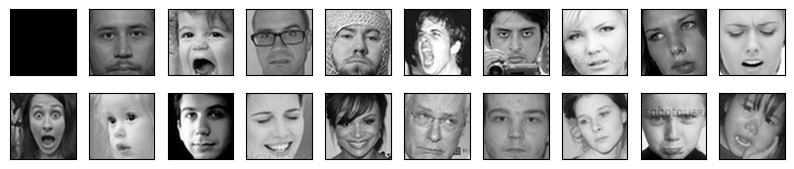

In [ ]:
import os
import glob
import numpy as np
import tensorflow as tf

# slect some image files.

#n_to_show = 10
#selected_indices = np.random.choice(range(n_all_images), n_to_show)
#selected_paths = all_file_paths[selected_indices]

nw_path = './nw'

split = 0.05
INPUT_DIM = (48, 48, 3)


picture_size = 48
folder_path = "."
TRAIN_DATA_DIR = 'train'
TEST_DATA_DIR = 'test'

#folder_path = "/content/drive/MyDrive/test/FER-2013"
#TRAIN_DATA_DIR = '/content/drive/MyDrive/test/FER-2013/train'
#TEST_DATA_DIR = '/content/drive/MyDrive/test/FER-2013/test'

data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1.0/255
    )

data_flow = data_gen.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size = INPUT_DIM[:2],
    batch_size = batch_size,
    shuffle=True,
    class_mode = 'input'
    )

val_data_flow = data_gen.flow_from_directory(
    TEST_DATA_DIR,
    target_size = INPUT_DIM[:2],
    batch_size = batch_size,
    shuffle=True,
    class_mode = 'input'
    )

shape = (1, 48,48,3)
Ax = np.empty(shape)

shape = (1,7)
Ay = np.array((1, 7))
print(Ax.shape)
i=0
steps_per_epoch = len(data_flow)
print(f"steps_per_epoch = {steps_per_epoch}")
for (x_batch, y_batch) in data_flow:
    #print(x_batch.shape)
    Ax=np.concatenate((Ax,x_batch), axis=0)
    #print(y_batch.shape)
    #Ay=np.concatenate((Ay,y_batch), axis=0)
    i += 1
    if (i == steps_per_epoch):
        break

x_data= Ax
print(x_data.shape)
#y_data= Ay
#print(y_data.shape)


print(len(data_flow))
print(len(val_data_flow))
#x_data=data_flow

fidle.scrawler.images(x_data[:20], None, indices='all', columns=10, x_size=1,y_size=1,y_padding=0, save_as='01-original')


(28709, 48, 48, 1)


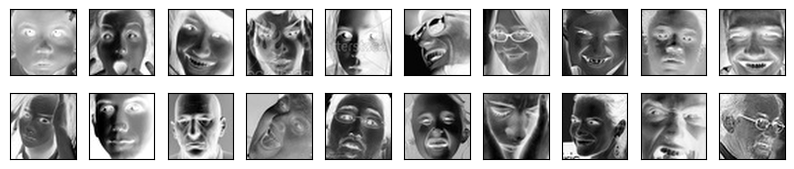

In [13]:
x_data= Ax[1:,:,:,:]
print(x_data.shape)
fidle.scrawler.images(x_data[:20], None, indices='all', columns=10, x_size=1,y_size=1,y_padding=0, save_as='01-original')


In [96]:
import os
import glob
import numpy as np
import tensorflow as tf

# slect some image files.

#n_to_show = 10
#selected_indices = np.random.choice(range(n_all_images), n_to_show)
#selected_paths = all_file_paths[selected_indices]

nw_path = './nw'

split = 0.05
INPUT_DIM = (48, 48, 3)
BATCH_SIZE = batch_size

picture_size = 48
folder_path = "."
TRAIN_DATA_DIR = 'train'
TEST_DATA_DIR = 'test'

#folder_path = "/content/drive/MyDrive/test/FER-2013"
#TRAIN_DATA_DIR = '/content/drive/MyDrive/test/FER-2013/train'
#TEST_DATA_DIR = '/content/drive/MyDrive/test/FER-2013/test'

data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1.0/255
    )

data_flow = data_gen.flow_from_directory(
    TRAIN_DATA_DIR,
    #color_mode = "grayscale",
    target_size = INPUT_DIM[:2],
    batch_size = BATCH_SIZE,
    shuffle=True,
    class_mode='categorical',
    )

val_data_flow = data_gen.flow_from_directory(
    TEST_DATA_DIR,
    target_size = INPUT_DIM[:2],
    #color_mode = "grayscale",
    batch_size = BATCH_SIZE,
    shuffle=True,
    class_mode='categorical',
    )

shape = (1, 48,48,3)
Ax = np.empty(shape)

shape = (1,7)
Ay = np.empty(shape)
print(Ay.shape)
i=0
steps_per_epoch = len(data_flow)
print(f"steps_per_epoch = {steps_per_epoch}")
for (x_batch, y_batch) in data_flow:
    #print(x_batch.shape)
    Ax=np.concatenate((Ax,x_batch), axis=0)
    #print(y_batch.shape)
    Ay=np.concatenate((Ay,y_batch), axis=0)
    i += 1
    if (i == steps_per_epoch):
        break

x_data= Ax
print(x_data.shape)
y_data= Ay
print(y_data.shape)

#np.save("/content/drive/MyDrive/test/FER-2013/x_data",x_data)
#np.save("/content/drive/MyDrive/test/FER-2013/y_datay",y_data)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
(1, 7)
steps_per_epoch = 225
(28710, 48, 48, 3)
(28710, 7)


In [ ]:
Ay = np.zeros((1, 7))
i=0
steps_per_epoch = len(train_set)
print(f"steps_per_epoch = {steps_per_epoch}")
for (x_batch, y_batch) in train_set:
    Ay=np.concatenate((Ay,y_batch), axis=0)
    i += 1
    if (i == steps_per_epoch):
        break
print(Ay.shape)
Ay=Ay[1:]
print(Ay.shape)
np.save("/content/drive/MyDrive/test/FER-2013/y_datay",Ax)

steps_per_epoch = 449
(28710, 7)
(28709, 7)


In [97]:
Ax=Ax[1:]
Ay=Ay[1:]
x_data= Ax
y_data= Ay
np.save("/content/drive/MyDrive/test/FER-2013/x_datay",x_data)
np.save("/content/drive/MyDrive/test/FER-2013/y_datay",y_data)

## Step 4 - Build model
In this example, we will use a **custom model**.
For this, we will use :
 - `SamplingLayer`, which generates a vector z from the parameters z_mean and z_log_var - See : [SamplingLayer.py](./modules/layers/SamplingLayer.py)
 - `VAE`, a custom model with a specific train_step - See : [VAE.py](./modules/models/VAE.py)

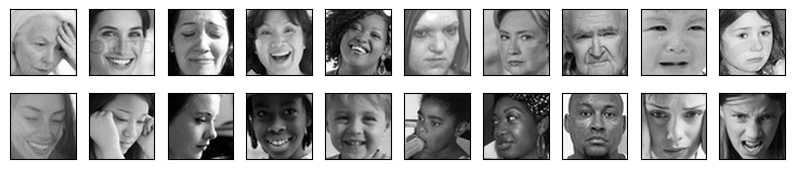

In [98]:

fidle.scrawler.images(x_data[:20], None, indices='all', columns=10, x_size=1,y_size=1,y_padding=0, save_as='01-original')

#### Encoder

In [99]:
inputs    = keras.Input(shape=(48, 48, 3))
x         = layers.Conv2D(32, 3, strides=1, padding="same")(inputs)
x         = tf.keras.layers.BatchNormalization()(x)
x         = tf.keras.layers.LeakyReLU()(x)
x         = tf.keras.layers.Dropout(rate = 0.25)(x)
x         = layers.Conv2D(64, 3, strides=2, padding="same")(x)
x         = tf.keras.layers.BatchNormalization()(x)
x         = tf.keras.layers.LeakyReLU()(x)
x         = tf.keras.layers.Dropout(rate = 0.25)(x)
x         = layers.Conv2D(64, 3, strides=2, padding="same")(x)
x         = tf.keras.layers.BatchNormalization()(x)
x         = tf.keras.layers.LeakyReLU()(x)
x         = tf.keras.layers.Dropout(rate = 0.25)(x)
x         = layers.Conv2D(64, 3, strides=2, padding="same")(x)
x         = tf.keras.layers.BatchNormalization()(x)
x         = tf.keras.layers.LeakyReLU()(x)
x         = tf.keras.layers.Dropout(rate = 0.25)(x)
shape_before_flattening = tf.keras.backend.int_shape(x)[1:]
x         = layers.Flatten()(x)

x         = layers.Dense(16, activation="relu")(x)

z_mean    = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z         = SamplingLayer()([z_mean, z_log_var])

encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")
encoder.compile()
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv2d_20 (Conv2D)             (None, 48, 48, 32)   896         ['input_14[0][0]']               
                                                                                                  
 batch_normalization_42 (BatchN  (None, 48, 48, 32)  128         ['conv2d_20[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 leaky_re_lu_42 (LeakyReLU)     (None, 48, 48, 32)   0           ['batch_normalization_42[0]

#### Decoder

In [100]:
inputs  = keras.Input(shape=(latent_dim,))
x = tf.keras.layers.Dense(np.prod(shape_before_flattening))(x)
x = tf.keras.layers.Reshape(shape_before_flattening)(x)
x       = layers.Dense(6*6*64, activation="relu")(inputs)
x       = layers.Reshape((6, 6, 64))(x)
x       = layers.Conv2DTranspose(64, 3, strides=1, padding="same")(x)
x         = tf.keras.layers.BatchNormalization()(x)
x         = tf.keras.layers.LeakyReLU()(x)
x         = tf.keras.layers.Dropout(rate = 0.25)(x)
x       = layers.Conv2DTranspose(64, 3, strides=2, padding="same")(x)
x         = tf.keras.layers.BatchNormalization()(x)
x         = tf.keras.layers.LeakyReLU()(x)
x         = tf.keras.layers.Dropout(rate = 0.25)(x)
x       = layers.Conv2DTranspose(32, 3, strides=2, padding="same")(x)
x         = tf.keras.layers.BatchNormalization()(x)
x         = tf.keras.layers.LeakyReLU()(x)
x         = tf.keras.layers.Dropout(rate = 0.25)(x)
x = layers.Conv2DTranspose(3,  3, strides=2,padding="same")(x)
x         = tf.keras.layers.BatchNormalization()(x)
x         = tf.keras.layers.LeakyReLU()(x)
x         = tf.keras.layers.Dropout(rate = 0.25)(x)

outputs = tf.keras.layers.Activation('sigmoid')(x)
decoder = keras.Model(inputs, outputs, name="decoder")
decoder.compile()
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 200)]             0         
                                                                 
 dense_23 (Dense)            (None, 2304)              463104    
                                                                 
 reshape_13 (Reshape)        (None, 6, 6, 64)          0         
                                                                 
 conv2d_transpose_20 (Conv2D  (None, 6, 6, 64)         36928     
 Transpose)                                                      
                                                                 
 batch_normalization_46 (Bat  (None, 6, 6, 64)         256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_46 (LeakyReLU)  (None, 6, 6, 64)          0   

In [102]:
#classifieur
inputs  = keras.Input(shape=(latent_dim,))
x = tf.keras.layers.Dense(np.prod(shape_before_flattening))(x)
x       = layers.Dense(6*6*64)(inputs)
x         = tf.keras.layers.Dropout(rate = 0.25)(x)
x       = layers.Dense(16*16*64)(x)
x         = tf.keras.layers.BatchNormalization()(x)
x         = tf.keras.layers.LeakyReLU()(x)
x         = tf.keras.layers.Dropout(rate = 0.25)(x)
x       = layers.Dense(6*6*64)(x)
x         = tf.keras.layers.BatchNormalization()(x)
x         = tf.keras.layers.LeakyReLU()(x)
x         = tf.keras.layers.Dropout(rate = 0.25)(x)
x       = layers.Dense(7)(x)
x         = tf.keras.layers.BatchNormalization()(x)
x         = tf.keras.layers.LeakyReLU()(x)
x         = tf.keras.layers.Dropout(rate = 0.25)(x)
outputs = tf.keras.layers.Activation('softmax')(x)

decoder1 = keras.Model(inputs, outputs, name="decoder1")

decoder1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
decoder1.summary()


Model: "decoder1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 200)]             0         
                                                                 
 dense_29 (Dense)            (None, 2304)              463104    
                                                                 
 dropout_38 (Dropout)        (None, 2304)              0         
                                                                 
 dense_30 (Dense)            (None, 16384)             37765120  
                                                                 
 batch_normalization_52 (Bat  (None, 16384)            65536     
 chNormalization)                                                
                                                                 
 leaky_re_lu_52 (LeakyReLU)  (None, 16384)             0         
                                                          

#### VAE
`VAE` is a custom model with a specific train_step - See : [VAE.py](./modules/models/VAE.py)

In [103]:
vae = VAE(encoder, decoder, loss_weights)

vae.compile(optimizer='adam')


Fidle VAE is ready :-)  loss_weights=[100, 0.7]


## Step 5 - Train
### 5.1 - Using two nice custom callbacks :-)
Two custom callbacks are used:
 - `ImagesCallback` : qui va sauvegarder des images durant l'apprentissage - See [ImagesCallback.py](./modules/callbacks/ImagesCallback.py)
 - `BestModelCallback` : qui sauvegardera le meilleur model - See [BestModelCallback.py](./modules/callbacks/BestModelCallback.py)

In [104]:
run_dir='/content/drive/MyDrive/test/VAE/'
callback_images      = ImagesCallback(x=x_data, z_dim=latent_dim, nb_images=5, from_z=True, from_random=True, run_dir=run_dir)
callback_bestmodel   = BestModelCallback( run_dir + '/models/best_model.h5' )
callback_tensorboard = TensorBoard(log_dir=run_dir + '/logs', histogram_freq=1)

callbacks_list = [callback_images, callback_bestmodel]

### 5.2 - Let's train !
With `scale=1`, need 1'15 on a GPU (V100 at IDRIS) ...or 20' on a CPU  

In [105]:
epochs = 10
chrono=fidle.Chrono()
chrono.start()

history = vae.fit(data_flow, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list, verbose=fit_verbosity)

chrono.show()

Epoch 1/10


ValueError: ignored

## Step 6 - Training review
### 6.1 - History

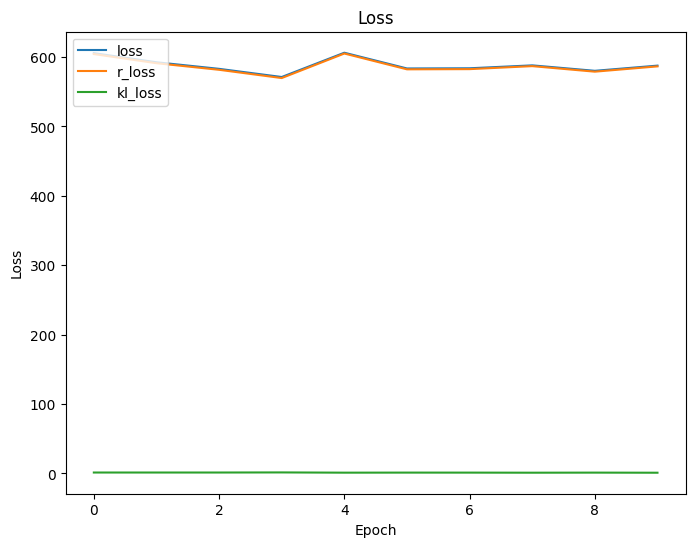

In [83]:



fidle.scrawler.history(history,  plot={"Loss":['loss','r_loss', 'kl_loss']}, save_as='history')

### 6.2 - Reconstruction during training
At the end of each epoch, our callback saved some reconstructed images.  
Where :  
Original image -> encoder -> z -> decoder -> Reconstructed image

<br>**Original images :**

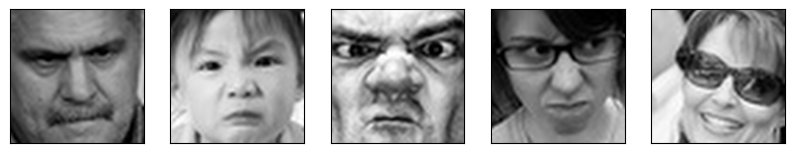

<br>**Encoded/decoded images**

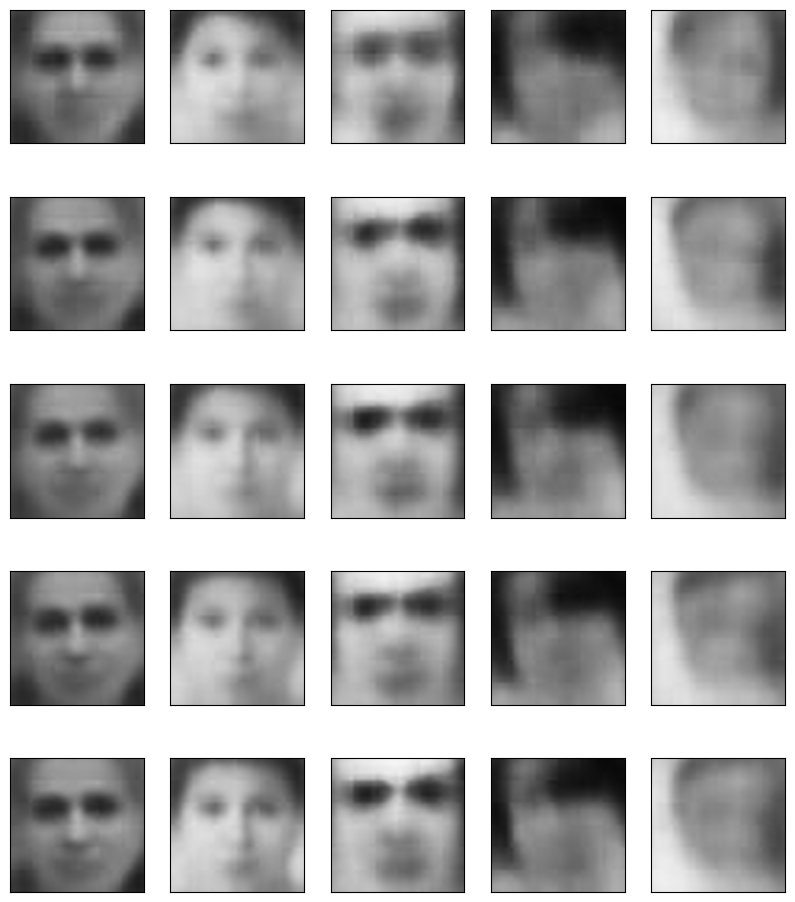

<br>**Original images :**

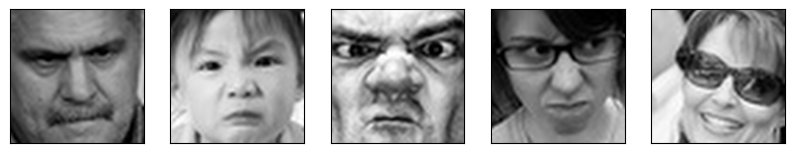

In [84]:
images_z, images_r = callback_images.get_images( range(0,epochs,2) )

fidle.utils.subtitle('Original images :')
fidle.scrawler.images(x_data[:5], None, indices='all', columns=5, x_size=2,y_size=2, save_as='02-original')

fidle.utils.subtitle('Encoded/decoded images')
fidle.scrawler.images(images_z, None, indices='all', columns=5, x_size=2,y_size=2, save_as='03-reconstruct')

fidle.utils.subtitle('Original images :')
fidle.scrawler.images(x_data[:5], None, indices='all', columns=5, x_size=2,y_size=2, save_as=None)


### 6.3 - Generation (latent -> decoder) during training

<br>**Generated images from latent space**

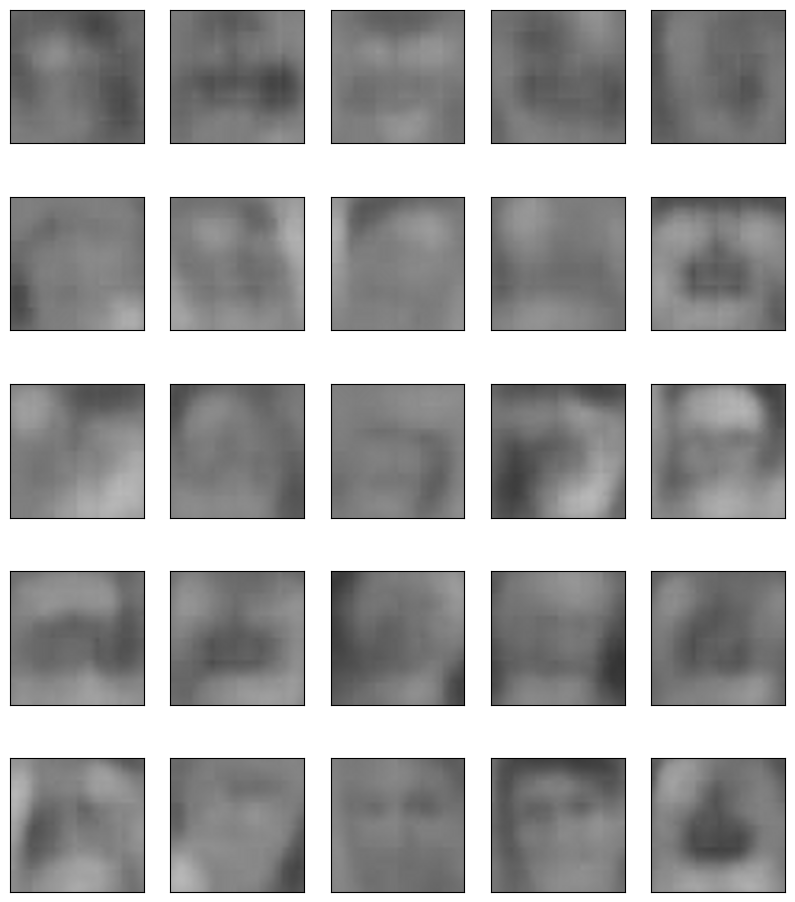

In [86]:
fidle.utils.subtitle('Generated images from latent space')
fidle.scrawler.images(images_r, None, indices='all', columns=5, x_size=2,y_size=2, save_as='04-encoded')

## Step 7 - Model evaluation

### 7.1 - Reload best model

In [87]:
vae=VAE()
vae.reload(f'{run_dir}/models/best_model')

Fidle VAE is ready :-)  loss_weights=[1, 1]
Reloaded.


### 7.2 - Image reconstruction

1/1 [==============================] - 0s 182ms/step


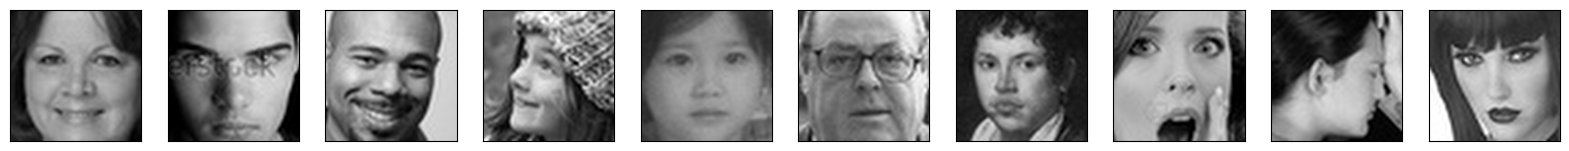

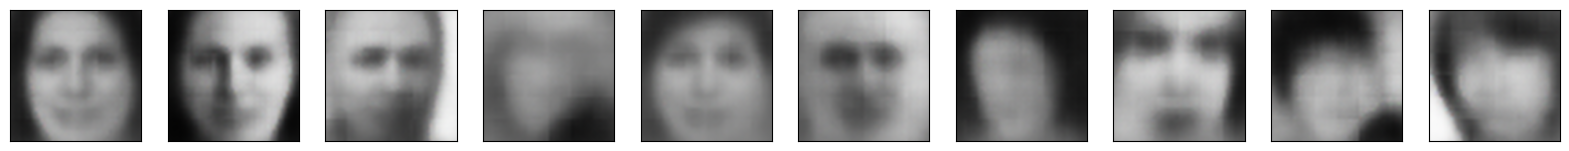

In [88]:
# ---- Select few images

x_show = fidle.utils.pick_dataset(x_data, n=10)

# ---- Get latent points and reconstructed images

z_mean, z_var, z  = vae.encoder.predict(x_show)
x_reconst         = vae.decoder.predict(z)

# ---- Show it

labels=[ str(np.round(z[i],1)) for i in range(10) ]
fidle.scrawler.images(x_show,    None, indices='all', columns=10, x_size=2,y_size=2, save_as='05-original')
fidle.scrawler.images(x_reconst, None, indices='all', columns=10, x_size=2,y_size=2, save_as='06-reconstruct')





In [89]:
print(y_data.shape)
shape=(y_data.shape[0],1)
M=np.empty(shape)
print(M.shape)
for i in range(y_data.shape[0]):
  M[i]=y_data[i].dot(2**np.arange(7)[::-1])
print(y_data)
print(M)

(28709, 7)
(28709, 1)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 1. 0. 0.]]
[[64.]
 [64.]
 [64.]
 ...
 [64.]
 [ 1.]
 [ 4.]]


### 7.3 - Visualization of the latent space

188/188 [==============================] - 11s 56ms/step


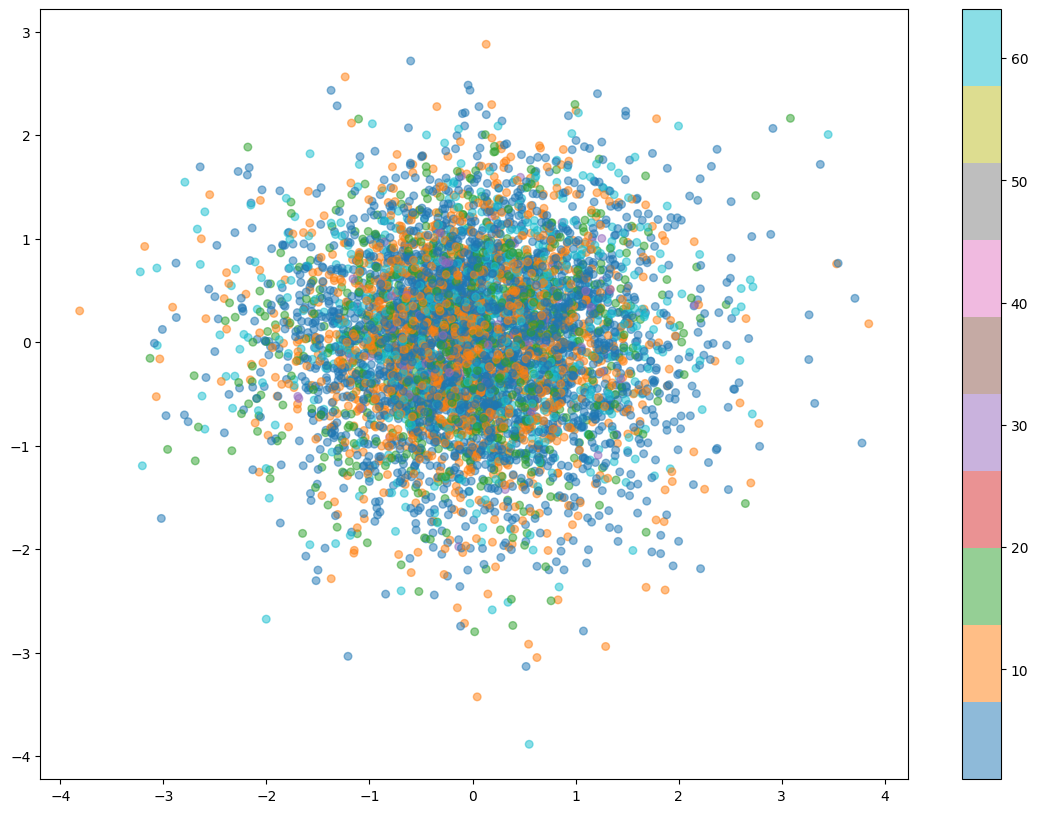

In [90]:
n_show = int(20000*scale)

# ---- Select images

x_show, y_show = fidle.utils.pick_dataset(x_data,M, n=n_show)

# ---- Get latent points

z_mean, z_var, z = vae.encoder.predict(x_show)

# ---- Show them

fig = plt.figure(figsize=(14, 10))
plt.scatter(z[:, 0] , z[:, 1], c=y_show, cmap= 'tab10', alpha=0.5, s=30)
plt.colorbar()
fidle.scrawler.save_fig('07-Latent-space')
plt.show()

### 7.4 - Generative latent space

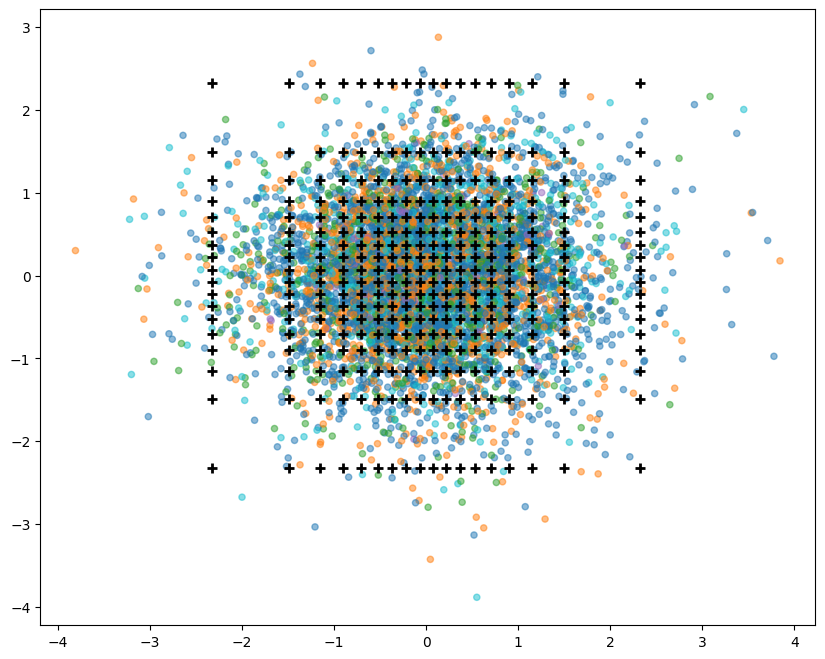

ValueError: ignored

In [91]:
if latent_dim<2:

    print('Sorry, This part can only work if the latent space is of dimension 2')

else:

    grid_size   = 18
    grid_scale  = 1

    # ---- Draw a ppf grid

    grid=[]
    for y in scipy.stats.norm.ppf(np.linspace(0.99, 0.01, grid_size),scale=grid_scale):
        for x in scipy.stats.norm.ppf(np.linspace(0.01, 0.99, grid_size),scale=grid_scale):
            grid.append( (x,y) )
    grid=np.array(grid)

    # ---- Draw latentspoints and grid

    fig = plt.figure(figsize=(10, 8))
    plt.scatter(z[:, 0] , z[:, 1], c=y_show, cmap= 'tab10', alpha=0.5, s=20)
    plt.scatter(grid[:, 0] , grid[:, 1], c = 'black', s=60, linewidth=2, marker='+', alpha=1)
    fidle.scrawler.save_fig('08-Latent-grid')
    plt.show()

    # ---- Plot grid corresponding images

    x_reconst = vae.decoder.predict([grid])
    fidle.scrawler.images(x_reconst, indices='all', columns=grid_size, x_size=0.5,y_size=0.5, y_padding=0,spines_alpha=0.1, save_as='09-Latent-morphing')



In [ ]:
fidle.end()

---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>